In [2]:
from glob import glob
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics.simulated_annealing_multi_order import simulated_annealing_multi_order
from thoi.measures.gaussian_copula_hot_encoded import nplets_measures_hot_encoded

* Exaustivo y quedarnos con:
  * AUC: min, median, max
  * bet k por order de iteración (1000)
* Greedy:
  * AUC
  * ML cross-val (para el notebook)
* simulated annealing multi order:
  * AUC
  * ML cross-val (para el notebook)

In [3]:
from scipy.stats import wilcoxon
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

import time

def wilcoxon_metric(batched_res: torch.Tensor, metric:str='o'):
    
    '''
    Get the metric from the batched results returning the average over the D axis.

    params:
    - batched_res (np.ndarray): The batched results with shape (batch_size, D, 4) where 4 is the number of metrics (tc, dtc, o, s). D = 2*n_subjects where [0, D/2) are from the group 1 and [D/2, D) are from the group 2.
    - metric (str): The metric to test the difference. One of tc, dtc, o or s
    '''
    
    METRICS = ['tc', 'dtc', 'o', 's']
    metric_idx = METRICS.index(metric)
    
    batch_size, D = batched_res.shape[:2]
    
    # |batch_size| x |D/2|
    group1 = batched_res[:, :D//2, metric_idx]
    group2 = batched_res[:, D//2:, metric_idx]
    
    # for each batch item compute the wilcoxon test
    # |batch_size|
    pvals = torch.tensor([
        wilcoxon(group1[i].cpu().numpy(), group2[i].cpu().numpy(), alternative='two-sided').pvalue
        for i in range(batch_size)
    ])
    
    return pvals

def auc_metric(batched_res: torch.Tensor, metric:str='o'):
    
    '''
    Get the metric from the batched results returning the average over the D axis.

    params:
    - batched_res (np.ndarray): The batched results with shape (batch_size, D, 4) where 4 is the number of metrics (tc, dtc, o, s). D = 2*n_subjects where [0, D/2) are from the group 1 and [D/2, D) are from the group 2.
    - metric (str): The metric to test the difference. One of tc, dtc, o or s
    '''
    
    METRICS = ['tc', 'dtc', 'o', 's']
    metric_idx = METRICS.index(metric)

    n_subjects = batched_res.shape[1] // 2    
    
    # Prepare de data    
    batched_X = batched_res[..., metric_idx].cpu().numpy()
    y = np.concatenate([np.zeros(n_subjects), np.ones(n_subjects)])
    
    # Prepare the output
    return torch.tensor([roc_auc_score(y, X) for X in batched_X])

def cross_val_ml_metric(batched_res: torch.Tensor, metric:str='o', classifier=None):
    
    '''
    Get the metric from the batched results returning the average over the D axis.

    params:
    - batched_res (np.ndarray): The batched results with shape (batch_size, D, 4) where 4 is the number of metrics (tc, dtc, o, s). D = 2*n_subjects where [0, D/2) are from the group 1 and [D/2, D) are from the group 2.
    - metric (str): The metric to test the difference. One of tc, dtc, o or s
    '''
    
    if classifier is None:
        classifier = LogisticRegression()
    
    t = time.time()
    METRICS = ['tc', 'dtc', 'o', 's']
    metric_idx = METRICS.index(metric)

    n_subjects = batched_res.shape[1] // 2    
    
    # Prepare de data    
    batched_X = [x for x in batched_res[..., metric_idx].cpu().numpy()]
    groups = np.concatenate([np.arange(n_subjects),np.arange(n_subjects)])
    y = np.concatenate([np.zeros(n_subjects), np.ones(n_subjects)])
    
    # Prepare the classifier
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', classifier)
    ])
    
    # Compute the leave one out cross validation roc auc score
    auc_scores = []
    for X in batched_X:
        # Compute the leave one out cross validation roc auc score
        logo = LeaveOneGroupOut()
        y_prob = np.zeros_like(y)
        for train_idx, test_idx in logo.split(X, y, groups):
            clf.fit(X[train_idx].reshape(-1, 1), y[train_idx])
            y_prob[test_idx] = clf.predict_proba(X[test_idx].reshape(-1, 1))[:,1]
        
        auc_scores.append(roc_auc_score(y, y_prob))
        
    total_time = time.time() - t

    return torch.tensor(auc_scores)


In [4]:
root = '/home/laouen.belloli/Documents/data/Oinfo/fmri_anesthesia/42003_2023_5063_MOESM3_ESM/nets_by_subject'
#states_all = ['Awake', 'Deep', 'Mild', 'Recovery']
states_all = ['Awake', 'Deep']

dfs_dict = {}
for state in states_all:
    # list all folder in root/state
    folders = glob(os.path.join(root, state, '*'))
    for folder in folders:
        network = os.path.basename(folder).replace('_parcellation_5', '')
        
        # List all csv files in folder
        csv_files = glob(os.path.join(folder, f'ts_{network}_parcellation_5_Sub*.csv'))
        for csv_file in csv_files:
            sub = int(os.path.basename(csv_file).split('_')[-1].split('.')[0].replace('Sub', ''))
            
            # Read csv file and add information columns
            df = pd.read_csv(csv_file, sep=',', header=None)
            
            # Convert the columns in multilavel, add the network to a second lavel
            df.columns = pd.MultiIndex.from_product([[network], range(df.shape[1])])
            
            # Add df to dfs dict
            if sub not in dfs_dict:
                dfs_dict[sub] = {}
            
            if state not in dfs_dict[sub]:
                dfs_dict[sub][state] = []
            
            dfs_dict[sub][state].append(df)

# Concatenate all dataframes into a single one
dfs_list = []
for sub, states in dfs_dict.items():
    for state, dfs in states.items():
        df = pd.concat(dfs, axis=1)
        df['sub'] = sub
        df['state'] = state
        df = df[[('sub',''), ('state','')] + [col for col in df.columns if col[0] not in ['sub', 'state']]]
        dfs_list.append(df)

df = pd.concat(dfs_list, axis=0)

# Remove sub10 that has no some missing networks
df = df[df['sub'] != 10]

# Check Show missing values (should be none), all subjects have all the networks
assert df.isnull().sum().sum() == 0, 'There are missing values'

# Check all subjects have same lenght across states and networks
assert df.groupby(['sub','state']).size().unique() == [245], 'Series lenght is not the same for all subjects'

networks = df.columns.get_level_values(0).unique()[2:]
#network_pairs = list(combinations(networks, 2))

# Create the list of datsa
Xs = [
    df[(df['sub'] == sub) & (df['state'] == state)][networks].values
    for state in states_all
    for sub in sorted(df['sub'].unique())
]

print(networks)

df

Index(['VentralAttn', 'CinguloParie', 'Visual', 'SMmouth', 'SMhand',
       'CinguloOperc', 'RetrosplenialTemporal', 'Default', 'Auditory',
       'DorsalAttn', 'FrontoParietal'],
      dtype='object')


sub  state VentralAttn                         CinguloParie              \
                         0     1     2     3     4            0     1     2   
0    12  Awake       -0.26  0.50  0.36  0.12  0.33        -0.04 -0.14 -0.03   
1    12  Awake       -0.56  0.01 -0.13  0.15 -0.23         0.75 -0.56 -0.79   
2    12  Awake       -0.67  0.34 -0.18  0.26  0.13         1.09 -0.53 -0.67   
3    12  Awake       -0.64  1.28  0.22  0.49  1.32         0.93 -0.02  0.26   
4    12  Awake       -0.62  1.77  0.69  0.75  2.35         0.58  0.54  1.12   
..   ..    ...         ...   ...   ...   ...   ...          ...   ...   ...   
240   5   Deep       -0.45 -0.27  1.06  0.55  1.01        -2.20  0.66 -0.26   
241   5   Deep        0.08 -0.07  1.26  0.46  1.48        -2.35  0.96  0.28   
242   5   Deep        0.68  0.01  0.91  0.11  1.36        -1.73  0.92  0.93   
243   5   Deep        0.68  0.01  0.37 -0.17  0.78        -0.86  0.57  0.88   
244   5   Deep       -0.00  0.01 -0.09 -0.24  0.02        -0.10  0.04  0.05   

     ... DorsalAttn                         FrontoParietal                    \
     ...          0     1     2     3     4              0     1     2     3   
0    ...      -0.02  0.20 -0.14  0.08  0.07           0.27  0.07  0.13  0.16   
1    ...      -0.81 -1.36 -1.52 -0.71  0.13          -1.06 -1.06 -0.32  0.31   
2    ...      -0.98 -2.05 -2.35 -1.16  0.09          -1.40 -1.42 -0.30  0.44   
3    ...      -0.45 -1.66 -2.36 -1.11  0.04          -0.60 -0.86  0.19  0.56   
4    ...       0.29 -0.70 -1.70 -0.65  0.21           0.58  0.07  0.75  0.71   
..   ...        ...   ...   ...   ...   ...            ...   ...   ...   ...   
240  ...       1.32  0.23  0.24  2.04  2.31          -1.43 -0.39 -0.10  0.85   
241  ...       0.83  0.44  0.48  2.47  1.45          -0.77 -0.36 -0.12  0.59   
242  ...      -0.10  0.22  0.54  1.88  0.17           0.09 -0.16 -0.13  0.09   
243  ...      -0.46 -0.07  0.34  0.89 -0.38           0.37  0.01 -0.13 -0.17   
244  ...      -0.06 -0.22 -0.06 -0.01 -0.02          -0.00  0.08 -0.14 -0.10   

           
        4  
0   -0.23  
1   -0.90  
2   -1.31  
3   -1.32  
4   -0.95  
..    ...  
240 -1.40  
241 -1.30  
242 -0.59  
243 -0.04  
244  0.09  

[7840 rows x 57 columns]

# Greedy

In [5]:
from thoi.heuristics import greedy

solution_greedy, scores_greedy = greedy(Xs, repeat=50, metric=auc_metric, largest=True, use_cpu=True)
solution_greedy = solution_greedy.numpy()
scores_greedy = scores_greedy.numpy()

In [12]:
best_nplets = [
    scores_greedy.mean(axis=0).argmax()+3,
    scores_greedy.max(axis=0).argmax()+3
]

best_nplets = [
    {
        'order': order,
        'repeat': scores_greedy[:, order-3].argmax(),
        'score': scores_greedy[scores_greedy[:, order-3].argmax(), order-3]
    } for order in best_nplets
]

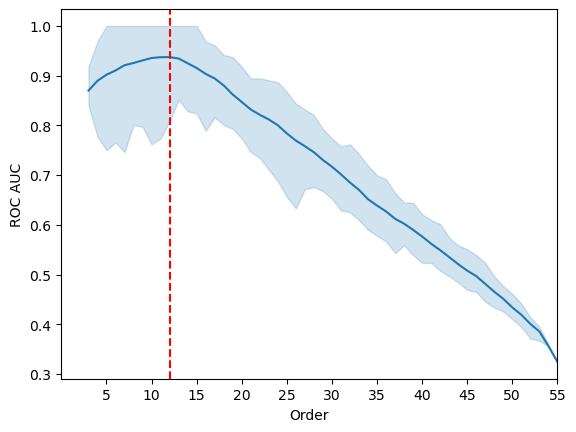

In [13]:
best_order, best_repeat, best_score = best_nplets[0].values()

df_scores_greedy = pd.DataFrame([
    (o+3, r, scores_greedy[r, o])
    for o in range(scores_greedy.shape[1])
    for r in range(scores_greedy.shape[0])
], columns=['order', 'repeat', 'score'])

ax = sns.lineplot(
    x='order',
    y='score',
    data=df_scores_greedy,
    dashes=False,
    errorbar=lambda x: (x.min(), x.max())
)

# Plot a line in the maximum mean o
ax.axvline(best_order, color='red', linestyle='--')

ax.set_xlim(0,df_scores_greedy['order'].max())

ax.set_xlabel('Order')
ax.set_ylabel('ROC AUC')
#ax.set_yscale('log')

# set x ticks at 5, 10, 15, 20, 25, ...
ax.set_xticks(np.arange(5, 56, 5))
    
plt.show()

In [8]:
best_order = scores_greedy.max(axis=0).argmax()
best_repeat = scores_greedy[:, best_order].argmax()
best_score = scores_greedy[best_repeat, best_order]

best order 12
best repeat 20
best score 1.0


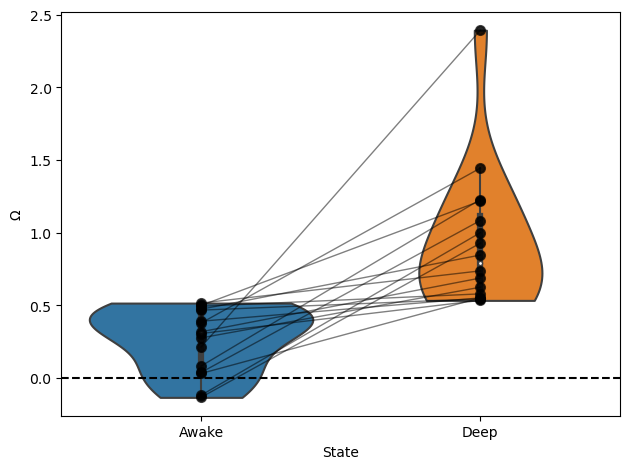

best order 5
best repeat 0
best score 1.0


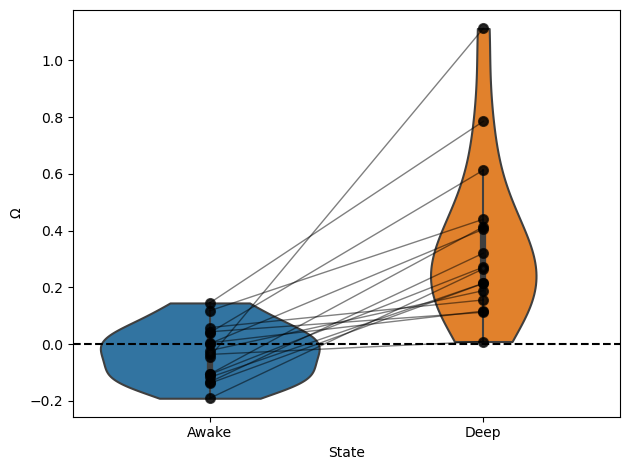

In [9]:
for nplet in best_nplets:
    best_order, best_repeat, best_score = nplet.values()
    
    print('best order', best_order)
    print('best repeat', best_repeat)
    print('best score', best_score)
    
    nplet_all = np.arange(Xs[0].shape[1])
    o_all = nplets_measures(Xs, np.array([nplet_all]))[0,:,2]

    # Get the best nplet at the best_order
    nplet_best = solution_greedy[best_repeat,:best_order+3]

    o_best = nplets_measures(Xs, nplet_best.reshape(1,-1))[0,:,2]

    w = wilcoxon(o_best[:len(o_best) // 2], o_best[len(o_best) // 2:], alternative='two-sided')

    df_greedy_best = pd.DataFrame({
        'o': o_best,
        'subject': np.concatenate([np.arange(16), np.arange(16)]),
        'state': np.concatenate([np.repeat('Awake', 16), np.repeat('Deep', 16)])
    })

    # Plot violin plots of the best nplets with state in the x acess and o in the y axis
    ax = sns.violinplot(data=df_greedy_best, x='state', y='o', cut=0, alpha=0.5)

    # add stripplot and connect the dots between the same subjects
    sns.stripplot(
        data=df_greedy_best,
        x='state',
        y='o',
        jitter=False,          # Disable jitter for alignment
        size=8,
        color='black',
        edgecolor='gray',
        alpha=0.7,
        ax=ax
    )

    # Connect each subject's paired measurements with lines
    for subject, subject_data in df_greedy_best.groupby('subject'):
        subject_data = subject_data.sort_values('state')
        plt.plot(
            subject_data['state'],
            subject_data['o'],
            marker='o',
            color='black',
            alpha=0.5,
            linewidth=1
        )

    ax.set_xlabel('State')
    ax.set_ylabel(r'$\Omega$')

    plt.axhline(0, color='black', linestyle='--')

    plt.xlim(-0.5, len(states_all) - 0.5)
    plt.tight_layout()
    plt.show()

In [10]:
mask = scores_greedy > 0.9

valid_nplets = [
    solution_greedy[r,:o+3]
    for o in range(scores_greedy.shape[1])
    for r in range(scores_greedy.shape[0])
    if mask[r, o]
]

In [18]:
delta.flatten().shape

torch.Size([8112])

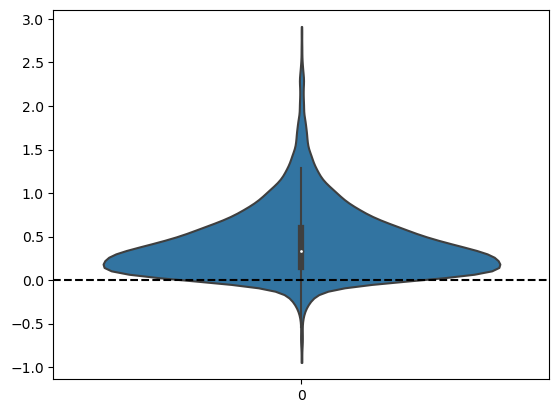

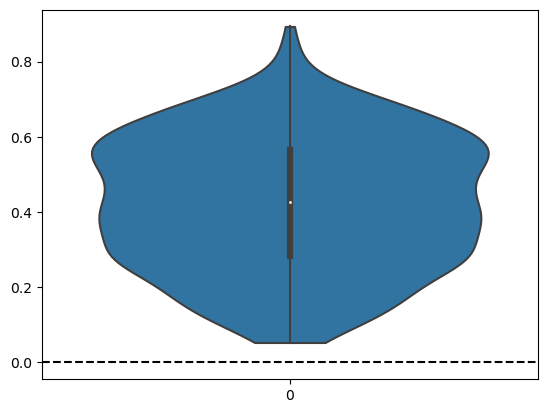

In [23]:
# TODO: add the automatic index to hot encoded in the library to be transparent
# convert nplets index to hot encoded
nplets = np.zeros((len(valid_nplets), 55))
for i, nplet in enumerate(valid_nplets):
    nplets[i, nplet] = 1
nplets

#res = nplets_measures_hot_encoded(Xs, nplets)

awake = res[:,:16,2]
deep = res[:,16:,2]
delta = deep - awake

# plot dist of deltas
ax = sns.violinplot(delta.flatten().reshape(-1,1), cut=0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

# Plot dist of the subjects mean of the deltas
ax = sns.violinplot(delta.mean(axis=1).flatten().view(-1,1), cut=0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [32]:
solution_annealing_multi_order, scores_annealing_multi_order = simulated_annealing_multi_order(Xs, repeat=100, metric=cross_val_ml_metric, largest=True, use_cpu=True)
print('solution.shape:', solution_annealing_multi_order.shape)
print('scores.shape:', scores_annealing_multi_order.shape)

mean(cross_val_ml_metric) = 0.690078125 - ES: 0:   1%|          | 10/1000 [00:34<57:36,  3.49s/it] 


KeyboardInterrupt: 

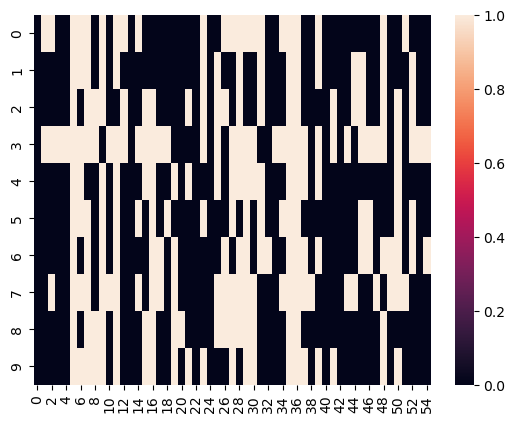

In [31]:
sns.heatmap(solution_annealing_multi_order.cpu().numpy())

plt.show()

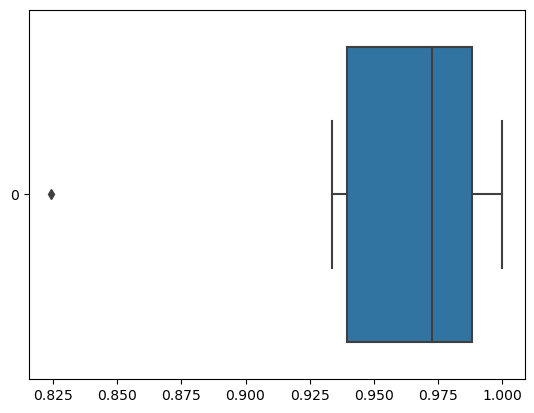

In [29]:
# plot lineplots for each row of scores 

sns.boxplot(data=scores_annealing_multi_order.cpu().numpy().flatten(), orient='h')
ax.set_title('Scores for each row of the solution')
ax.set_xlabel('Repeat')
ax.set_ylabel('')
    
plt.show()

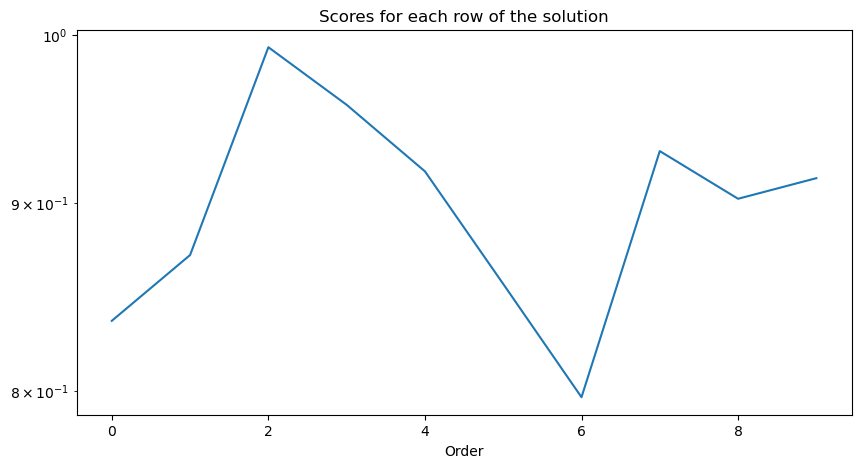

In [7]:
# Calculate for each subject and state the measures for the entire brain
Xs = np.array([
    group[networks].values
    for _, group in df.groupby(['sub','state'])
])

df_all = nplets_measures(Xs, use_cpu=True)
df_all = pd.DataFrame(df_all, columns=['tc','dtc','o','s'])
df_all

,tc,dtc,o,s
0,49.719593,30.231443,19.488150,79.951036
1,48.058706,32.586466,15.472240,80.645172
2,45.718645,30.381168,15.337476,76.099813
3,49.203786,30.597021,18.606765,79.800807
4,52.366868,32.066411,20.300457,84.433279
...,...,...,...,...
59,48.880246,30.684057,18.196189,79.564303
60,47.726063,29.280635,18.445429,77.006698
61,50.845508,28.961616,21.883891,79.807124
62,41.898590,29.353142,12.545449,71.251732


Greede donde se obtiene la npleta que maximiza la varianza (o estadistico de diferencia) entre los estados